In [1]:
from rocketpy import Rocket, Environment, Flight, LiquidMotor, Fluid, CylindricalTank, MassFlowRateBasedTank, MassBasedTank
from math import exp
from datetime import datetime, timedelta
from CoolProp.CoolProp import PropsSI
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import excel_sheet_functions as ex

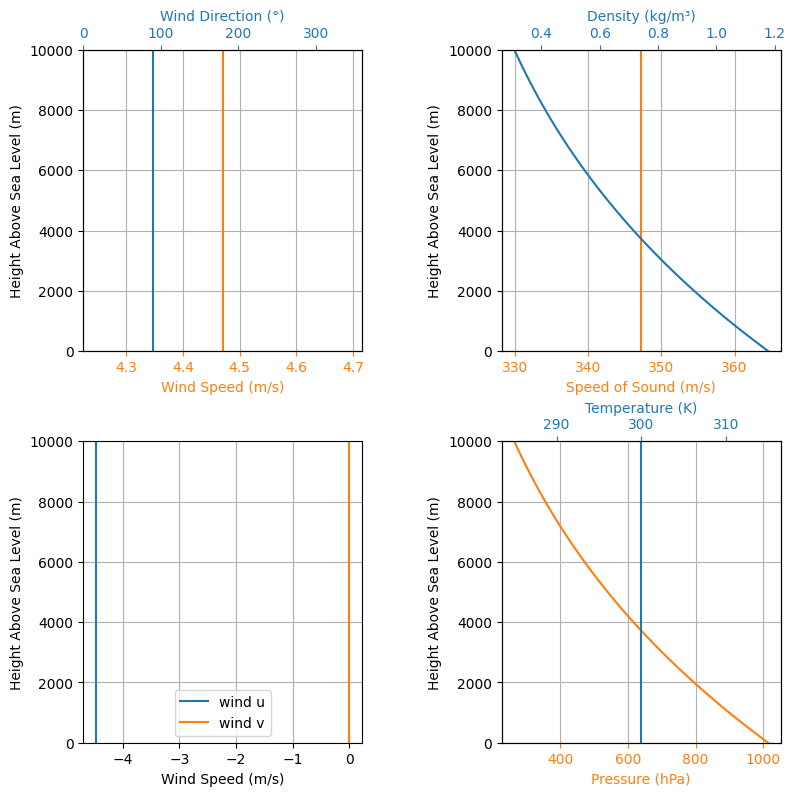


Gravity Details

Acceleration of gravity at surface level:    9.7922 m/s²
Acceleration of gravity at  10.000 km (ASL): 9.7614 m/s²


Launch Site Details

Launch Site Latitude: 28.61000°
Launch Site Longitude: -80.60000°
Reference Datum: SIRGAS2000
Launch Site UTM coordinates: -47949.74 W    3177626.96 N
Launch Site UTM zone: 17R
Launch Site Surface Elevation: 0.0 m


Atmospheric Model Details

Atmospheric Model Type: custom_atmosphere
custom_atmosphere Maximum Height: 10.000 km

Surface Atmospheric Conditions

Surface Wind Speed: 4.47 m/s
Surface Wind Direction: 90.00°
Surface Wind Heading: 270.00°
Surface Pressure: 1013.25 hPa
Surface Temperature: 300.00 K
Surface Air Density: 1.177 kg/m³
Surface Speed of Sound: 347.22 m/s


Earth Model Details

Earth Radius at Launch site: 6373.27 km
Semi-major Axis: 6378.14 km
Semi-minor Axis: 6356.75 km
Flattening: 0.0034


Atmospheric Model Plots



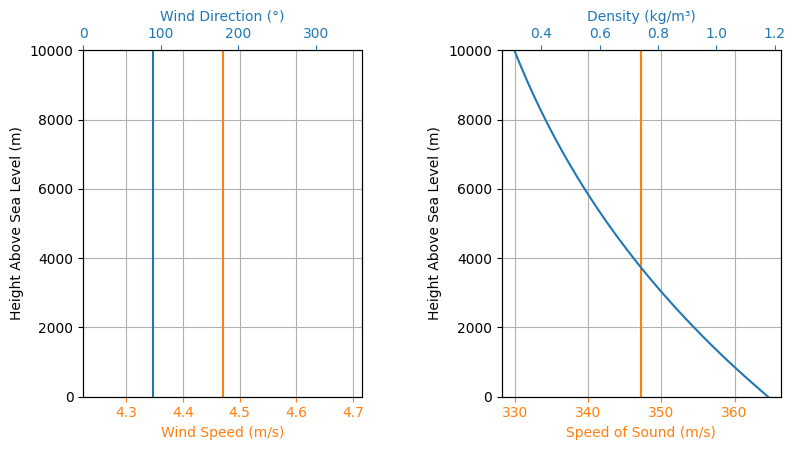

In [2]:
#open rocket from Oskar
env = Environment( 
    latitude=28.61,
    longitude=-80.6, # from OR
)
env.set_atmospheric_model(
    type="custom_atmosphere",
    pressure=None,
    temperature=300,
    wind_u=[
        (0, -4.47), # 5 m/s at 0 m
        (1000, -4.47), # 10 m/s at 1000 m
        (5000, -4.47),
    ],
    wind_v=[
        (0, 0), # -2 m/s at 0 m
        (1000, 0), # 3 m/s at 500 m
        (5000, 0), # 2 m/s at 1000 m
    ],
)
env.set_elevation(0) # from OR
env.max_expected_height = 10000
env.plots.atmospheric_model()

env.info()

In [3]:
# Stałe dla turbulencji
external_tank_diameter = 0.2
tank_height = 1.13
thickness_tank = 0.005
thickness_piston = 0.01

# Parametry, które potrzebuję
p_0 = 63e5 #ciśnienie początkowe
piston_position = 0.85
total_oxidizer_mass = 18
flux_time = 11.2 # the start time will be useful as well
# csv z masą utleniacza i paliwa w czasie
ethanol_temperature = 300
# Parametry, które zakładem
gas_initial_mass_fuel = 0

# Parametry, które wyliczam
N20_liq_density = PropsSI("D", "P", p_0, "Q", 0, "NitrousOxide")
N20_gas_density = PropsSI("D", "P", p_0, "Q", 1, "NitrousOxide")
ethanol_liq_density = PropsSI("D", "P", p_0-1e5, "T", ethanol_temperature, "Ethanol") # PropSI pokazuje 63e5 powyżej krytycznego, dlatego odejmuję
ethanol_gas_density = PropsSI("D", "P", p_0-1e5, "Q", 1, "Ethanol")

volume_tank = 0.25*np.pi*(external_tank_diameter-2*thickness_tank)**2*tank_height
volume_piston = 0.25*np.pi*(external_tank_diameter-2*thickness_tank)**2*thickness_piston
volume_oxidizer = piston_position*volume_tank
volume_fuel = volume_tank - volume_oxidizer - volume_piston

gas_initial_mass_ox = (volume_oxidizer - (total_oxidizer_mass / N20_liq_density)) / (1/N20_gas_density - 1/N20_liq_density)
liquid_initial_mass_ox = total_oxidizer_mass - gas_initial_mass_ox
liquid_initial_mass_fuel = volume_fuel * ethanol_liq_density

# Parametry stricte pod tank_geometry
tank_radius = (external_tank_diameter - 2*thickness_tank) / 2
adjusted_height_ox = piston_position*tank_height
adjusted_height_fuel = tank_height - adjusted_height_ox - thickness_piston

# Dla sprawdzenia czy wychodzi mi to samo co volume_oxidizer i volume_fuel
fuel_tank_volume = np.pi * tank_radius**2 * adjusted_height_fuel
oxidizer_tank_volume = np.pi * tank_radius**2 * adjusted_height_ox

In [4]:
oxidizer_liq = Fluid(name="N2O_l", density=N20_liq_density)
oxidizer_gas = Fluid(name="N2O_g", density=N20_gas_density)
fuel_liq = Fluid(name="ethanol_l", density=ethanol_liq_density) 
fuel_gas = Fluid(name="ethanol_g", density=ethanol_gas_density)

In [5]:
# Tank geometry
oxidizer_tank_geometry = CylindricalTank(
    radius=tank_radius,
    height=adjusted_height_ox,
)
fuel_tank_geometry = CylindricalTank(
    radius=tank_radius,
    height=adjusted_height_fuel,
)

In [6]:
# Define tanks
mass_flow_rate_liq = round(liquid_initial_mass_ox/flux_time, 2) - 0.005 # waiting for csv
mass_flow_rate_gas = round(gas_initial_mass_ox/flux_time - 0.005, 2) # waiting for csv

oxidizer_tank = MassFlowRateBasedTank(
    name="oxidizer tank",
    geometry=oxidizer_tank_geometry,
    flux_time=(1, flux_time+1), 
    initial_liquid_mass=liquid_initial_mass_ox, 
    initial_gas_mass=gas_initial_mass_ox,
    liquid_mass_flow_rate_in=0,
    liquid_mass_flow_rate_out=mass_flow_rate_liq, 
    gas_mass_flow_rate_in=0,
    gas_mass_flow_rate_out=mass_flow_rate_gas, 
    liquid=oxidizer_liq,
    gas=oxidizer_gas,
)

In [7]:
#Fuel tank
fuel_mass_flow_rate = liquid_initial_mass_fuel / flux_time - 0.01
fuel_tank = MassFlowRateBasedTank(
    name="fuel tank",
    geometry=fuel_tank_geometry,
    flux_time=(1, flux_time+1),
    initial_liquid_mass=liquid_initial_mass_fuel-0.00001, #Same as above, only guess
    initial_gas_mass=gas_initial_mass_fuel,
    liquid_mass_flow_rate_in=0,
    liquid_mass_flow_rate_out=fuel_mass_flow_rate, #heuristics
    gas_mass_flow_rate_in=0,
    gas_mass_flow_rate_out=0,
    liquid=fuel_liq,
    gas=fuel_gas,
)

In [8]:
z4000 = LiquidMotor(
    thrust_source=".\\data\\AGH-SS_Z4000-10sBurn-optimal.eng", #From tests
    dry_mass=2.7,
    dry_inertia=(0.02143, 0.02143, 0.005535), #This should be calculated using CAD, here I use estimations
    nozzle_radius=0.036, #From technical report
    center_of_dry_mass_position=0.144, #Estimated from openrocket
    nozzle_position=0,
    burn_time=14.4,
    coordinate_system_orientation="nozzle_to_combustion_chamber",
)
z4000.add_tank(tank=oxidizer_tank, position=1.285) #From nozzle to center of the tank
z4000.add_tank(tank=fuel_tank, position=2.01)

In [9]:
trb = Rocket(
    radius=0.1,
    mass=58.367, 
    inertia=(75.502, 75.502, 0.43), 
    power_off_drag=".\\data\\powerondrag.csv",  
    power_on_drag='.\\data\\powerondrag.csv',
    center_of_mass_without_motor=2.75, 
    coordinate_system_orientation="nose_to_tail", 
)
trb.add_motor(z4000, position=4.49)

In [10]:
#Aerodynamic surfaces taken from openrocket
nose_cone = trb.add_nose(
    length=0.7, kind="lvhaack", position=0
)

fin_set = trb.add_trapezoidal_fins(
    n=4,
    root_chord=0.287,
    tip_chord=0.059,
    span=0.202,
    sweep_length=0.228,
    position=4.21,
    cant_angle=0,
)

tail = trb.add_tail(
    top_radius=0.1, bottom_radius=0.065, length=0.287, position=4.21
)

rail_buttons = trb.set_rail_buttons(
    upper_button_position=2.17, #Just some value, not accurate
    lower_button_position=3.5, #Just some value, not accurate
    angular_position=0, #Just some value, not accurate #0 stopni
)

main = trb.add_parachute(
    name="main",
    cd_s=12.72, # cd * parachute area
    trigger=1000,      
    sampling_rate=105,
    lag=6,
    noise=(0, 8.3, 0.5),
    radius=2.25, 
    height=2.25,
    porosity=0.0432,
)

drogue = trb.add_parachute(
    name="drogue",
    cd_s=1.218,
    trigger="apogee", 
    sampling_rate=105,
    lag=1,
    noise=(0, 8.3, 0.5),
    radius=0.76,
    height=0.76,
    porosity=0.0432,
)

# trb.draw()
# trb.plots.drag_curves()

In [11]:
test_flight = Flight(
    rocket=trb, environment=env, rail_length=15.24, inclination=87, heading=90
    )

In [ ]:
test_flight.all_info()

In [ ]:
test_flight.prints.out_of_rail_conditions()

In [ ]:
print(ex.rail_departure_velocity_in_ft_per_sec(test_flight))

In [ ]:
print(ex.average_thrust_during_rail_phase(test_flight, z4000, trb))

In [ ]:
print(ex.max_static_margin(test_flight))
print(ex.min_static_margin(test_flight))

In [ ]:
print(test_flight.max_acceleration)
print(ex.max_acceleration(test_flight))
print(ex.max_acceleration_in_g(test_flight))

In [ ]:
print(ex.max_acceleration_power_on_in_g(test_flight))

In [ ]:
print(ex.max_velocity_in_ft_per_sec(test_flight))

In [ ]:
print(ex.max_mach(test_flight))

In [ ]:
print(ex.max_q_in_psf_and_altitude_in_ft(test_flight))

In [ ]:
print(test_flight.apogee)
print(test_flight.apogee_time)
print(test_flight.apogee*3.28084)

In [ ]:
print(ex.max_pitch_moment(test_flight))
print(ex.max_yaw_moment(test_flight))

In [ ]:
print(ex.distance_from_pad(test_flight))

In [12]:
mach_df = ex.get_df_for_mach_number(test_flight)
aoa_df = ex.get_df_for_angle_of_attack(test_flight)
cog_df = ex.get_df_for_center_of_gravity(trb, test_flight)
cop_df = ex.get_df_for_center_of_pressure(trb, test_flight)
merged_cp_and_mach_df = ex.get_merged_df_for_cp_and_mach_number(trb, test_flight)
mach_df.head()
cog_df.tail()

,Time (s),Center of Mass Position (m)
95,11.747475,2.831110
96,11.860606,2.828896
97,11.973737,2.826639
98,12.086869,2.824338
99,12.200000,2.821992


In [ ]:
x_mach = np.array(cop_df["x"])
y_cop = np.array(cop_df["Scalar"])
font = {'family': 'serif',
        'color':  'black',
        'size': 12}
plt.plot(x_mach, y_cop)
plt.grid(color = 'gray', linestyle = '--', linewidth = 0.5)
plt.xlabel("Mach number", fontdict=font)
plt.ylabel("Center of pressure position (m)", fontdict=font)
plt.title("Center of pressure position vs Mach number", fontdict=font)
plt.show()

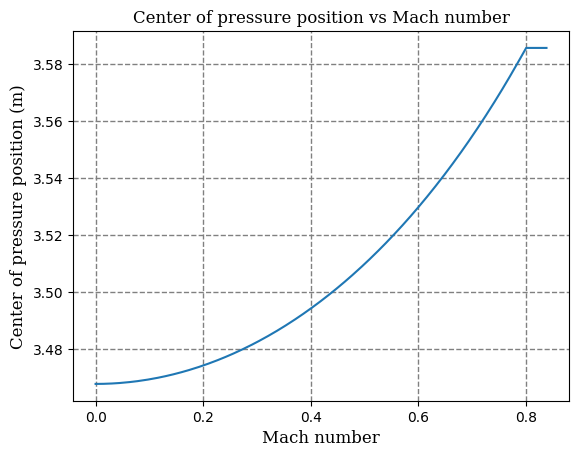

In [13]:
ex.plot_center_of_pressure_vs_mach_number(cop_df)

In [ ]:

y2_cog = np.array(cog_df["Center of Mass Position (m)"])
merged_cp_and_mach_df_reshaped = merged_cp_and_mach_df.groupby(merged_cp_and_mach_df.index // 10).mean()
x_time = np.array(merged_cp_and_mach_df_reshaped["Time"])
y_cop = np.array(merged_cp_and_mach_df_reshaped["Scalar"])
plt.plot(x_time, y_cop)
plt.plot(x_time, y2_cog)
plt.xlabel("Time (s)", fontdict=font)
plt.ylabel("Position (m)", fontdict=font)
plt.title("Center of pressure and center of gravity position vs time", fontdict=font)
plt.grid(color = 'gray', linestyle = '--', linewidth = 0.5)


In [ ]:
reshaped_aoa_df = aoa_df.iloc[:250, :]
merged_cp_and_mach_df_reshaped_to_250 = merged_cp_and_mach_df.groupby(merged_cp_and_mach_df.index // 4).mean()
merged_cp_and_mach_df_reshaped_to_250.head()
merged_cop_and_aoa_df = pd.merge_asof(
    reshaped_aoa_df, 
    merged_cp_and_mach_df_reshaped_to_250, 
    left_on='Time (s)', 
    right_on='Time', 
    direction='nearest'
)
x_aoa = np.array(merged_cop_and_aoa_df["Angle of Attack (°)"])
y_cop = np.array(merged_cop_and_aoa_df["Scalar"])
plt.plot(x_aoa, y_cop)
plt.xlabel("Angle of attack (deg)", fontdict=font)
plt.ylabel("Center of pressure position (m)", fontdict=font)
plt.title("Center of pressure position vs angle of attack", fontdict=font)
plt.grid(color = 'gray', linestyle = '--', linewidth = 0.5)

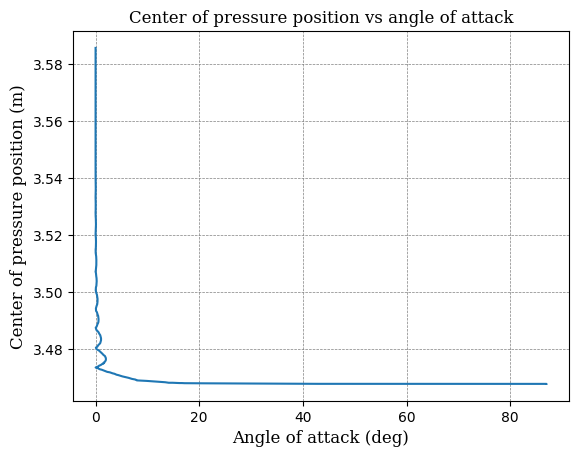

In [14]:
ex.plot_center_of_pressure_vs_angle_of_attack(merged_cp_and_mach_df, aoa_df)

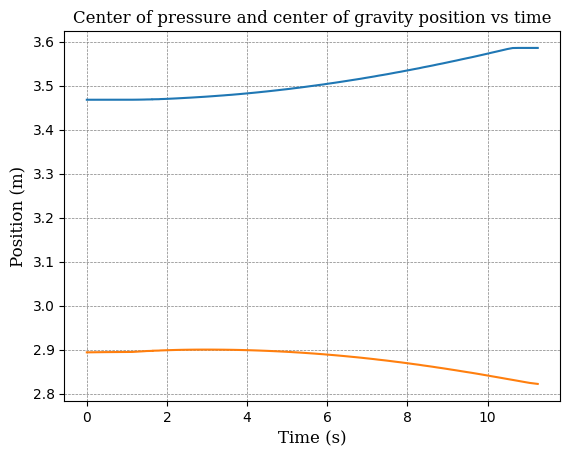

In [15]:
ex.plot_center_of_gravity_and_of_pressure_vs_time(cog_df, merged_cp_and_mach_df)